In [1]:
import numba, os, sys, time, pickle, resource, copy
import astropy.units as u, matplotlib.pyplot as plt
import numpy as np, scipy.ndimage as ndimage
from sys import path

from numpy.random import Generator, PCG64

from sunpy.map import Map
from sunpy.net import Fido,attrs as a, vso
from sunpy.time import TimeRange
from astropy.coordinates import SkyCoord
import importlib

crobar_path = '/home/jplowman/research/solar-physics/codebase/crobar/python_modules'
path.append(crobar_path)
from local_cartesian_transform import planar_map_coords, curved_map_coords, transform, transform_curved, wrld2pix
from loop_processing import filter_loops, resample_loops
from initial_points import volume_seed_points, fluxweighted_seed_points, region_seed_points, hilbert_seed_points
from label_loop_regions import label_loop_regions
from coord_grid import coord_grid
import forcefree_field
from util import estimate_aia_error, search_fido_response, bindown2, get_limb, get_limb_occlusion
from reconstruct_2comp_3Dloops import reconstruct, compute_fwdmat, get_3d_emission

plt.rcParams.update({'font.size': 18,'figure.figsize':[20,12],'image.origin':'lower'})

In [2]:
# Save files and arguments that need to go in the save file names:
# Save files and arguments that need to go in the save file names:
save_dir = 'save'
magnetogram_dir = 'data'
emission_dir = 'save'

# note, the following two files need to have been created externally. 
magnetogram_name = 'hmi.m_45s.2020.04.28_11_13_30_TAI.magnetogram.fits'
emis_name = 'radloss_iswat_042820.fits'
alpha = 3/1.0e11
alphastr = str(round(alpha/1.0e-11,3))

date = '2020/04/28 11:13:30'
datestr = '20200428_111330'

footpoint_savefile = os.path.join(save_dir,'footpoints_'+datestr+'.npz')
loop_savefile = os.path.join(save_dir,'loops_'+datestr+'_'+alphastr+'.npz')
loopid_savefile = os.path.join(save_dir,'loopids_'+datestr+'_'+alphastr+'.npz')
emis_configfile = os.path.join(save_dir,'emconfig_'+'_'+datestr+'_'+alphastr+'.npz')
emis_savefile = os.path.join(save_dir,'em3d_'+emis_name[0:-4]+'_'+datestr+'_'+alphastr+'.npz')

newpoints = 0 or not(os.path.exists(footpoint_savefile)) # Generate new seed points
newtrace = 0 or not(os.path.exists(loop_savefile)) # Retrace field lines
newfilter = 0
newmatrix = 1 or not(os.path.exists(emis_configfile)) # Make new forward matrix

In [3]:
# Configuration parameter aspects of the save files:
if(newpoints):
	footpoint_config = {'date':date,
						'datestr':datestr,
						'magnetogram_name':magnetogram_name,
						'length_unit':'cm',
						'pos_unit':'arcsec',
						'nloops_vol':300,
						'nloops_flux':12000,
						'ivp_z0_fac':0.02,
						'height_fac':0.85,
						'region_origin':[-280, -255],
						'region_size':[400,425],
						'ivp_boundpad':[[0.05,0.05,0.075],[-0.05,-0.05,-0.7]],
						'bounds_offset':[0.5,0.5,0.0]}
	np.savez_compressed(footpoint_savefile,**footpoint_config)

if(newtrace or newpoints):
	loop_config = {'dvox':[14e6,14e6,14e6],
				   'min_height':1.5*14e6,
				   'min_length':3.5*14e6,
				   'flt_dvox_fac':[1,1,10],
				   'vox_boundpad':[[0.05,0.05,0.001],[-0.05,-0.05,-0.1]],
				   'alpha':alpha,
				   'footpoint_savefile':os.path.basename(footpoint_savefile),
				   'tracer_pad':0.001}
	alphastr = str(round(loop_config['alpha']/1.0e-11,3))
	np.savez_compressed(loop_savefile,**loop_config)

if(newmatrix or newtrace or newpoints):
	emis_config = { 'temp1':0.9e6, # Temperature for estimating scale height of loop profile 1
					'temp2':0.9e6, # Temperature for estimating scale height of loop profile 2
					'xpo1':1.9, # Assumed exponential power law index of the temperature response function
					'psf_size_px':0.7,
				    'footpoint_savefile':os.path.basename(footpoint_savefile),
				    'loop_savefile':os.path.basename(loop_savefile),
					'emis_name':emis_name}
	np.savez_compressed(emis_configfile,**emis_config)

footpoint_config = dict(np.load(footpoint_savefile),allow_pickle=False)
loop_config = dict(np.load(loop_savefile),allow_pickle=False)
emis_config = dict(np.load(emis_configfile),allow_pickle=False)

emis_config['emis_name'] = emis_name

In [4]:
length_unit = u.Unit(str(footpoint_config['length_unit']))
pos_unit = u.Unit(str(footpoint_config['pos_unit']))

magnetogram_path = os.path.join(magnetogram_dir,str(footpoint_config['magnetogram_name']))
emis_path = os.path.join(emission_dir,str(emis_config['emis_name']))

In [5]:
gfac = 1.0/2.2
# An arcsecond from one AU
asec_cm = 1.49e13/(3600*180/np.pi)
nloops0 = footpoint_config['nloops_vol']+footpoint_config['nloops_flux']
flux_factor = loop_config['dvox'][0]*loop_config['dvox'][1]

# Massaging the x and y ranges:
def get_croprs(config):
	[[x0, y0], [xsz0, ysz0]] = config['region_origin'], config['region_size']
	[xl, yl, xh, yh] = [x0, y0, x0+xsz0, y0+ysz0]
	boundpad = config['ivp_boundpad']
	cropr = [x0-xsz0*(boundpad[0,0]/(1-boundpad[0,0])),x0+xsz0/(1+boundpad[1,0]),
	        y0-ysz0*(boundpad[0,1]/(1-boundpad[0,1])),y0+ysz0/(1+boundpad[1,1])]*u.arcsec
	cropr0 = [x0, x0+xsz0, y0, y0+ysz0]*pos_unit
	# Crop the data for the reconstruction in a bit compared to the cube. This improves the ability of the 
	# reconstruction to fit the data, although it does also mean that the edges of the reconstruction are 
	# underconstrained. 
	cropr_emis = cropr0 + np.array([10,-10,10,-10])*u.arcsec	
	return cropr, cropr_emis

cropr, cropr_emis = get_croprs(footpoint_config)

In [6]:
# Load and crop the magnetogram:
magnetogram = Map(magnetogram_path)
blc=SkyCoord(cropr[0],cropr[2],frame=magnetogram.coordinate_frame)
trc=SkyCoord(cropr[1],cropr[3],frame=magnetogram.coordinate_frame)
magnetogram = magnetogram.submap(blc,top_right=trc)

# Get the 'local' coordinate system for the magnetogram. In this coordinate system,
# the radial axis at image center (not necessarily coordinate center due to solar
# curvature) is the z axis, and the x axis is aligned with solar longitude.
vox_lct = transform_curved(magnetogram.center)

# Compute the coordinates of the magnetogram pixels and the magnetic field strengths
# corrected for inclination by assuming that the surface fiels are radial. Points too far
# from disk center are masked out. This code will also attempt to correct the line-of-sight
# fields to radial by assuming the field lines on the photosphere are radial.
[mag, mag_coords, good_mask] = curved_map_coords(magnetogram, lct=vox_lct)
mag_coords = mag_coords.to(length_unit).value

emis_map = Map(emis_path)
blc=SkyCoord(cropr_emis[0],cropr_emis[2],frame=emis_map.coordinate_frame)
trc=SkyCoord(cropr_emis[1],cropr_emis[3],frame=emis_map.coordinate_frame)
emis_map = emis_map.submap(blc,top_right=trc)

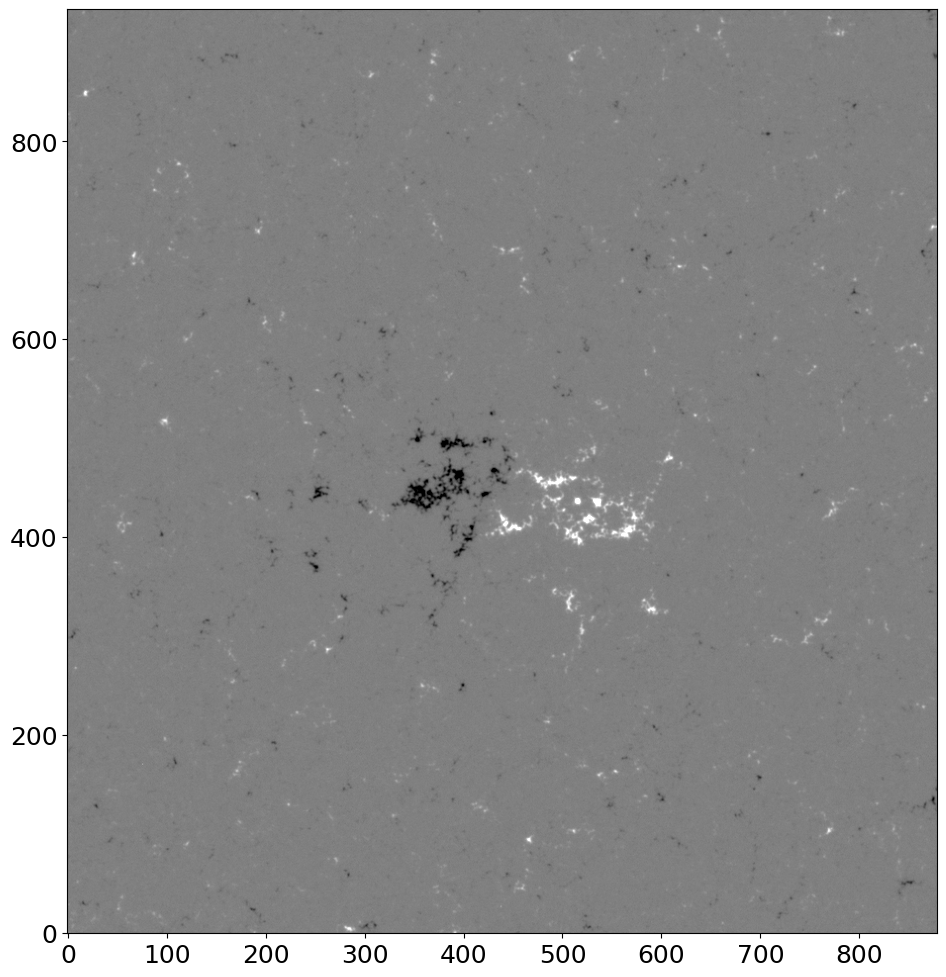

In [7]:
plt.imshow(np.flipud(np.fliplr(magnetogram.data)),cmap=plt.get_cmap('gray'),vmin=-500,vmax=500)

In [8]:
rsun_cm = magnetogram.center.rsun.to(length_unit).value

# Set up boundaries for overall region:
bounds0 = np.array([[np.min(c),np.max(c)] for c in mag_coords]).T
bounds0[1,2] = bounds0[0,2] + footpoint_config['height_fac']*np.min(bounds0[1,0:2]-bounds0[0,0:2])

heights = (mag_coords[0]**2+mag_coords[1]**2+(rsun_cm+mag_coords[2])**2)**0.5 - rsun_cm
# Boundaries for field line tracing are set slightly larger to avoid
# issues when an initial point falls outside the boundary:
tracer_bounds = copy.deepcopy(bounds0)
tracer_bounds[0,0] -= loop_config['tracer_pad']*(tracer_bounds[1,0]-tracer_bounds[0,0])
tracer_bounds[0,1] -= loop_config['tracer_pad']*(tracer_bounds[1,1]-tracer_bounds[0,1])
tracer_bounds[1,0] += loop_config['tracer_pad']*(tracer_bounds[1,0]-tracer_bounds[0,0])
tracer_bounds[1,1] += loop_config['tracer_pad']*(tracer_bounds[1,1]-tracer_bounds[0,1])
tracer_bounds[0,2] = np.max(heights)
tracer_bounds[1,2] = tracer_bounds[0,2] + bounds0[1,2]-bounds0[0,2] # np.max(mag_coords[2,:,:,:]) - bounds0[0,2]

# Get coordinate grids (see coord_grid.py for details of these)
def bounds2grid(bounds0,dvox,offsets=None,pad=None,frame=None):
    if(offsets is None): offsets = 0.5+0.0*dvox
    if(pad is None): pad = np.zeros([2,len(dvox)])
    if(frame is None): frame = np.arange(len(dvox))
    bounds = bounds0+pad*(bounds0[1]-bounds0[0])
    nvox = np.floor((bounds[1]-bounds[0])/dvox).astype(np.int32)
    vox_origin = bounds[0]+offsets*(bounds[1]-bounds[0]-nvox*dvox)
    return coord_grid(nvox,vox_origin,np.diag(dvox),frame)

# This is the grid for the voxels:
vox_grid = bounds2grid(bounds0,loop_config['dvox'],offsets=footpoint_config['bounds_offset'],pad=loop_config['vox_boundpad'])
# This is the grid used for generating initial points and filtering them:
flt_grid = bounds2grid(bounds0,loop_config['dvox']*loop_config['flt_dvox_fac'],offsets=footpoint_config['bounds_offset'])
vox0, dvox, nvox = vox_grid.origin, np.diag(vox_grid.fwd), vox_grid.dims
print(vox0, dvox, nvox)

[-1.64535924e+10 -1.69383135e+10 -4.22539514e+09] [14000000. 14000000. 14000000.] [2298 2399 1951]


In [9]:
# Field values and coordinates used for tracing the magnetogram 
# (commented out code will bin it down by a factor of 2 for faster testing):

mag_trace = copy.deepcopy(mag[:,:,0])
mag_coords_trace = copy.deepcopy(mag_coords[:,:,:,0])

#mag_trace = bindown2(mag[:,:,0],2)/4
#mag_coords_trace = np.array([bindown2(xa[:,:,0],2)/4 for xa in mag_coords])

In [10]:
if(newpoints):
	ivp_bounds = bounds0+footpoint_config['ivp_boundpad']*(bounds0[1]-bounds0[0])
	ivp_bounds[0,2]=0 # Need to make sure initial points are all above source surface...
	footpoint_config['volume_initial_points'] = volume_seed_points(footpoint_config['nloops_vol'], ivp_bounds)
	footpoint_config['fluxw_initial_points'] = hilbert_seed_points(footpoint_config['nloops_flux'], mag, mag_coords, 
																   footpoint_config['ivp_z0_fac']*dvox[2], rsun=rsun_cm)
	np.savez_compressed(footpoint_savefile,**footpoint_config)

use_points = np.vstack((footpoint_config['volume_initial_points'],footpoint_config['fluxw_initial_points']))

In [11]:
volume_initial_pt_pix = wrld2pix(vox_lct.coord(footpoint_config['volume_initial_points'].T*u.cm),magnetogram,magnetogram,vox_lct=vox_lct).T
fluxw_initial_pt_pix = wrld2pix(vox_lct.coord(footpoint_config['fluxw_initial_points'].T*u.cm),magnetogram,magnetogram,vox_lct=vox_lct).T

fluxw_initial_pt_pix = np.vstack(fluxw_initial_pt_pix)
volume_initial_pt_pix = np.vstack(volume_initial_pt_pix)

(0.0, 934.0)

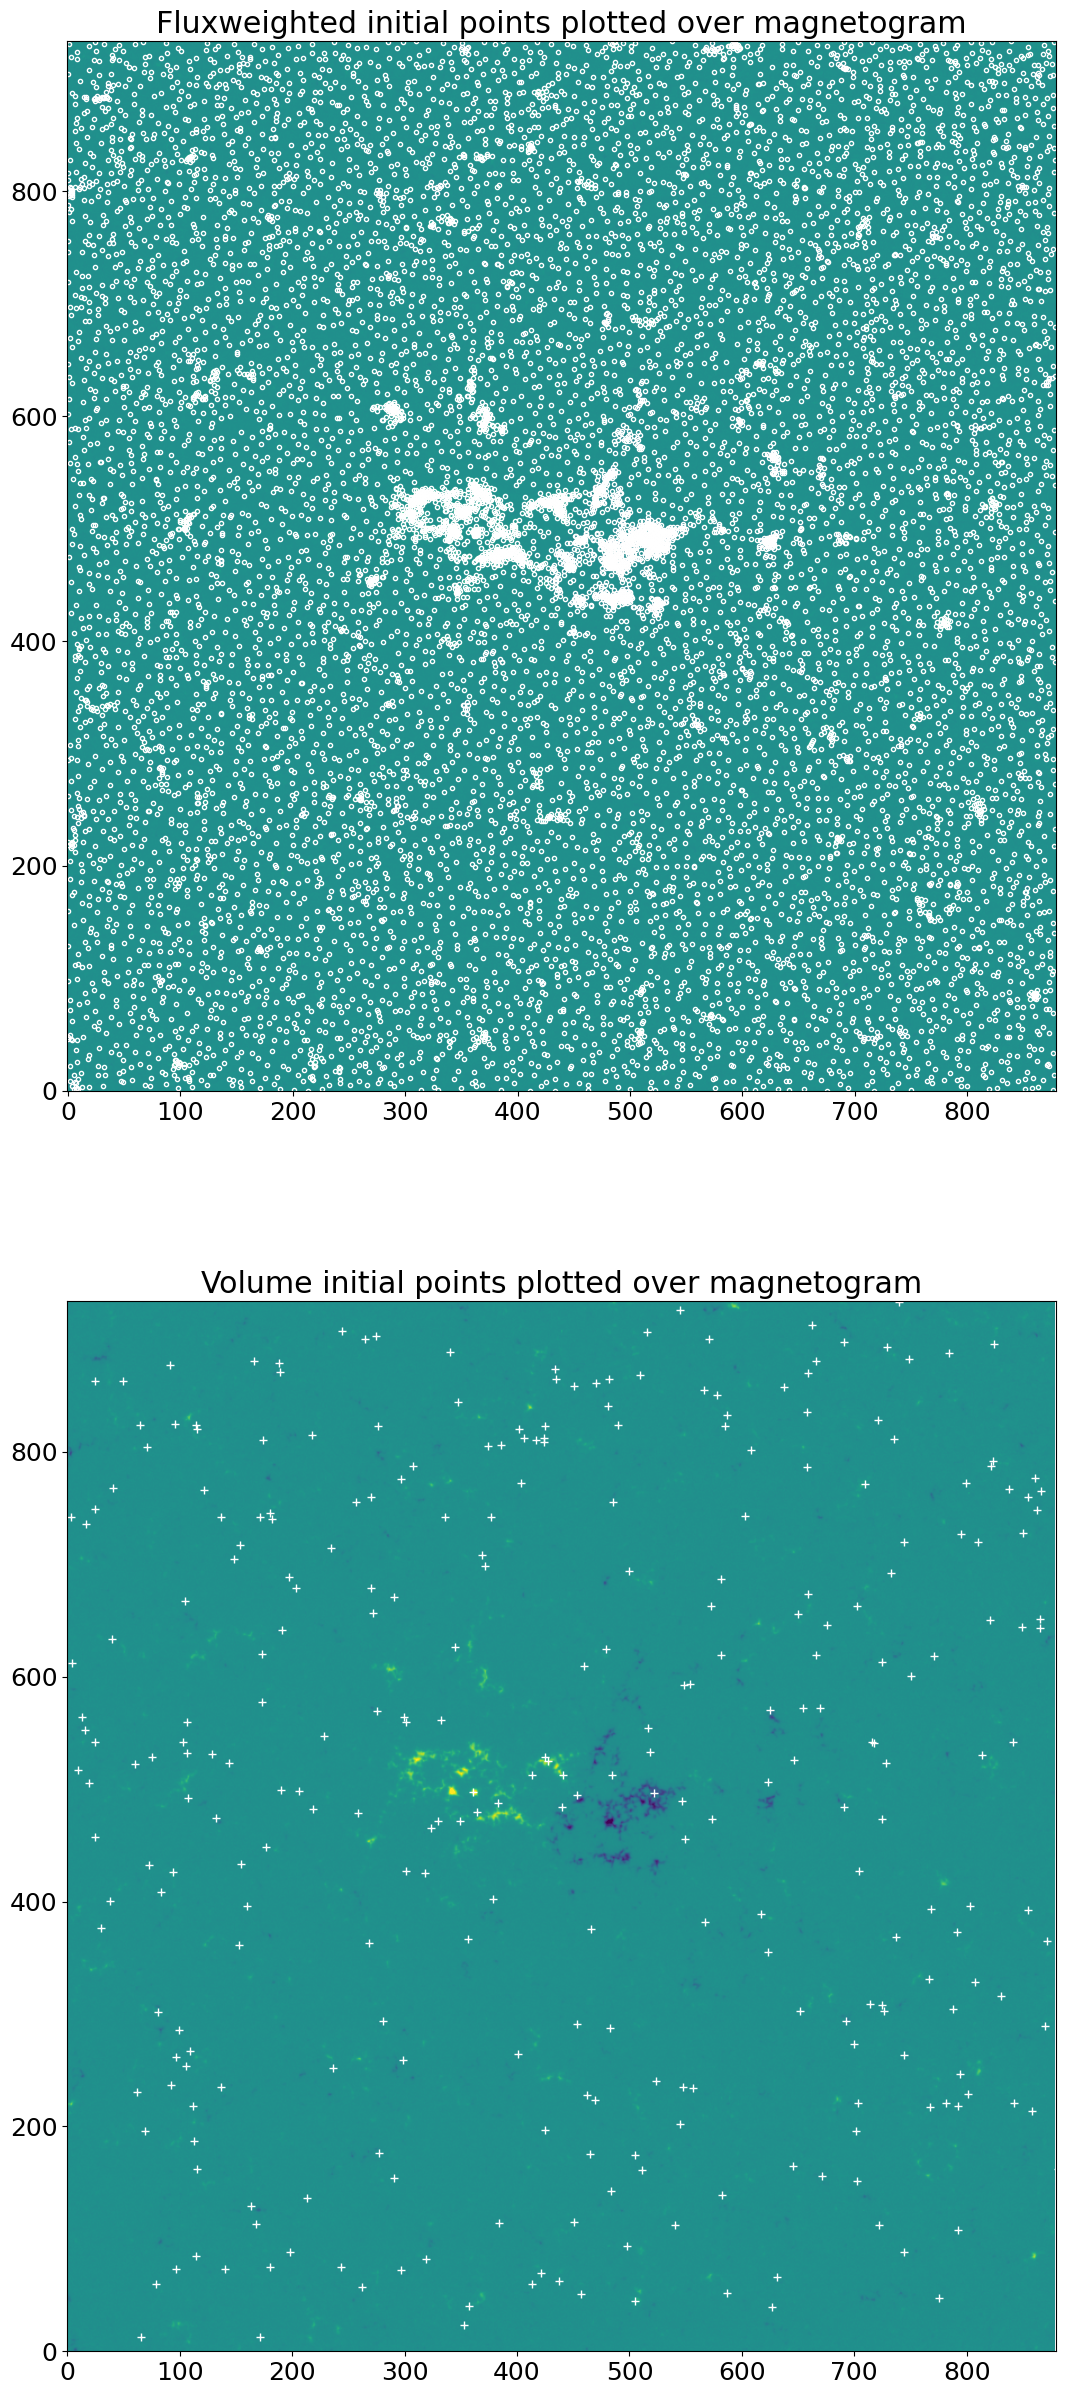

In [12]:
fig = plt.figure(figsize=[25,30])
extent = np.array([bounds0[0,0],bounds0[1,0],bounds0[0,1],bounds0[1,1]])/1.0e8

ax1 = fig.add_subplot(2,1,1)
ax1.imshow(mag[:,:,0],origin='lower',vmin=-1000,vmax=1000)
ax1.plot(fluxw_initial_pt_pix[:,1],fluxw_initial_pt_pix[:,0],'.',color='white', markerfacecolor='none')
ax1.set(title='Fluxweighted initial points plotted over magnetogram')

ax2 = fig.add_subplot(2,1,2)
ax2.imshow(mag[:,:,0],origin='lower',vmin=-1000,vmax=1000)
ax2.plot(volume_initial_pt_pix[:,1],volume_initial_pt_pix[:,0],'+',color='white')
ax2.set(title='Volume initial points plotted over magnetogram')
plt.xlim(0,mag.shape[1])
plt.ylim(0,mag.shape[0])

In [13]:
# Trace field lines if newtrace is true:
if(newtrace):
	fields0 = forcefree_field.tracer(use_points, mag_trace, mag_coords_trace, bounds=tracer_bounds, 
										alpha=alpha, rtol=1.0e-5,atol=0.001*dvox[0], boundrad=rsun_cm)
	fieldline_indices0 = np.hstack([i*np.ones(fields0[0][i].shape[0],dtype=np.int32) for i in range(0,len(fields0[0]))])
	loop_config['fieldline_indices0'] = fieldline_indices0
	loop_config['fieldlines0'] = np.vstack(fields0[0])
	loop_config['fieldline_strengths0'] = np.vstack(fields0[1])
	np.savez_compressed(loop_savefile,**loop_config)

In [14]:
# Unpack the coordinates from the loop config file:
fieldline_coords0 = [loop_config['fieldlines0'][loop_config['fieldline_indices0']==i] for i in range(0,loop_config['fieldline_indices0'][-1])]

if(newfilter):
	# Resample loops so that they're regularly spaced, and footpoints are at the photosphere (open ends exempted):
	[fieldlines_resamp,lengths] = resample_loops(fieldline_coords0,tracer_bounds,0.1*np.mean(dvox),rcurv=rsun_cm)
	
	# Filter out loops whose footpoints fall too close together:
	[fieldlines_filter,lengths_filter] = filter_loops(fieldlines_resamp, lengths, flt_grid, 
													  lmin=loop_config['min_length'], 
													  zmin = loop_config['min_height'], rcurv=rsun_cm)
	fieldline_indices = np.hstack([i*np.ones(fieldlines_filter[i].shape[0],dtype=np.int32) for i in range(0,len(fieldlines_filter))])
	loop_config['fieldline_indices'] = fieldline_indices
	loop_config['fieldlines_filter'] = np.vstack(fieldlines_filter)
	loop_config['lengths_filter'] = np.hstack(lengths_filter)
	np.savez_compressed(loop_savefile,**loop_config)
else:
	fieldlines_filter = [loop_config['fieldlines_filter'][loop_config['fieldline_indices']==i] for i in range(0,loop_config['fieldline_indices'][-1]+1)]
	lengths_filter = [loop_config['lengths_filter'][loop_config['fieldline_indices']==i] for i in range(0,loop_config['fieldline_indices'][-1]+1)]


nloops = len(fieldlines_filter)
print(nloops0,nloops)

12300 9291


In [15]:
# Create core voxel cube identifying every voxel with a loop:
if(newtrace or os.path.exists(loopid_savefile)==False):
	[loopids, loopid_info, voxel_loop_lengths] = label_loop_regions(fieldlines_filter, lengths_filter, vox_grid)
	loopid_info['voxel_loopids'] = loopids
	loopid_info['voxel_loop_lengths'] = voxel_loop_lengths
	loopid_info['loop_savefile'] = os.path.basename(loop_savefile)
	loopid_info['footpoint_savefile'] = os.path.basename(footpoint_savefile)
	np.savez_compressed(loopid_savefile,**loopid_info)

In [16]:
loopid_info = dict(np.load(loopid_savefile))
loopids = loopid_info['voxel_loopids']
voxel_loop_lengths = loopid_info['voxel_loop_lengths']

In [17]:
loopid_slice = loopid_info['voxel_loopids'][:,:,200]
loopflg = np.zeros(nloops+1,dtype='bool')+True
loopflg[nloops]=False
loopflg[np.where(loopid_info['looplengths'] < 3*np.max(dvox))]=False

loopflg0 = loopflg[loopid_slice]

In [18]:
limb_mask = get_limb(vox_grid, rsun_cm)

In [19]:
limb_mask[0:60,:,:] = False
limb_mask[-60:,:,:] = False
limb_mask[:,0:70,:] = False
limb_mask[:,-70:,:] = False

In [20]:
# Compute the forward matrix from the field-aligned regions to the data:
if(newmatrix):
	[amat,modelinputs] = compute_fwdmat(None, None, loopids, loopid_info,
	                                    vox_grid, cropr_emis, magnetogram, voxel_loop_lengths, curvature=False, 
	                                    vox_mask=limb_mask, xpo1 = emis_config['xpo1'], xpo2 = emis_config['xpo1'],
										temp1=emis_config['temp1'], temp2=emis_config['temp1'], map_in=emis_map,
	                                    psf_size_px=emis_config['psf_size_px'], zmin=np.min(mag_coords[2]), asym=True)
	foo = modelinputs.pop('map')
	emis_config.update(modelinputs)
	emis_config['amat_data'] = amat.data
	emis_config['amat_indices'] = amat.indices
	emis_config['amat_indptr'] = amat.indptr
	emis_config['amat_shape'] = amat.shape
	np.savez_compressed(emis_configfile,**emis_config)

None None 900000.0 900000.0 1.9 1.9 None None 6000.0 500.0 None -4255791063.2902527 3 None 0.7 True False None None None None SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA
Detector:		 AIA
Measurement:		 94.0 Angstrom
Wavelength:		 94.0 Angstrom
Observation Date:	 2020-04-28 11:15:00
Exposure Time:		 54.0 s
Dimension:		 [635. 676.] pix
Coordinate System:	 helioprojective
Scale:			 [0.60010898 0.60010898] arcsec / pix
Reference Pixel:	 [283.5 325. ] pix
Reference Coord:	 [-100.05185568  -50.06312737] arcsec                   
array([[35757.824, 35738.414, 36173.793, ..., 47915.92 , 47910.344,
        48369.758],
       [35649.098, 35780.94 , 36032.293, ..., 47838.477, 47682.824,
        48023.125],
       [35975.074, 35618.098, 35738.3  , ..., 47540.46 , 47513.594,
        47991.445],
       ...,
       [53214.465, 52857.082, 52508.152, ..., 39530.953, 38632.992,
        37755.574],
       [52774.02 , 52503.18 , 52457.047, ..., 39303.336, 38669.92 ,
        38122.293],
       

In [24]:
# Unpack the forward matrix from the configuration:
from scipy.sparse import csr_matrix
amat = csr_matrix((emis_config['amat_data'],emis_config['amat_indices'],emis_config['amat_indptr']), shape=emis_config['amat_shape'])
emis_config['map'] = emis_map # restore the emission map

In [25]:
import sparse_nlmap_solver
import reconstruct_2comp_3Dloops
importlib.reload(sparse_nlmap_solver)
importlib.reload(reconstruct_2comp_3Dloops)
from reconstruct_2comp_3Dloops import reconstruct

In [26]:
from scipy.sparse import diags
regmat = diags(1.0/emis_config['loop_weights']**2)

In [28]:
# Error estimates for the reconstruction:
meancount_normed = 400
err_map = copy.deepcopy(emis_config['map'])
normfac = 1/(meancount_normed/np.nanmean(err_map.data)) #norm_factor = 10
err_map.data[:,:] = err_map.data/normfac # norm. factor
chan1_err = estimate_aia_error(err_map, channel='AIA193_THIN')*normfac
data_corr = copy.deepcopy(emis_config['map'].data)
# Adjust reg_fac until final chi squared is about 1.75
solution = reconstruct(amat, emis_config, reg_fac=5.0e9, dat_xpo=1, errs=chan1_err, solver_tol=1.0e-5, data=data_corr, sqrmap=False, map_reg=False, regmat=regmat)

99.58540204301264 505.01901438538425 28493.390927380875
77213.21 77213.21
Guess0 min: 1241.0233 Guess0 max: 192669.81
Guess0 min: 7.1236916 Guess0 max: 12.168734
Overall regularization factor: 3.523904706813131e-10
33379.35649164493 44450259960.93875 11.254326 11.254326
3.920889e-06 0.000100834375
step scaling: 1.0 1.1206417 1.386294771213871
[35878380. 32464182. 26579636. 19690902. 13199502.  9395258.  6555089.]
2.41 s i = 0 chi2 = 234.95 step size = 0.85 reg. param. = 6554854.24 chi2 change = 29.2898 reg. change = 29323261.41774
Setup:  0.0842132568359375 Solver:  1.8596653938293457 Stepper:  0.46515846252441406
New combined FOM: 6555089.1853220835 Old combined FOM: 35878379.89285819 Change: 29323290.70753611
33264.66285644317 7447318009.437192 10.301781 11.255001
3.920889e-06 0.000100834375
step scaling: 1.0 1.0854197 1.386294771213871
[6555089.  5931325.5 4856225.5 3597680.5 2411717.8 1716684.6 1197791.6]
5.28 s i = 1 chi2 = 201.65 step size = 0.85 reg. param. = 1197590.0 chi2 chan

In [29]:
# The product of the field-aligned region solution vector and the forward matrix is the reconstruction's estimate
# of the AIA image. amat and the solution use a scaled version of the matrix which greatly improves convergence of 
# Krylov methods, hence the loop_weights factors. For a single forward matrix rescaling by the loop weights below
# isn't necessary, but for multiple forward matrices (e.g., multiple perspectives) it is:
soln = copy.deepcopy(solution[0])/emis_config['loop_weights']
aia_only_recon_dat_aia = (amat.T.dot(emis_config['loop_weights']*soln)).reshape(emis_config['map'].data.shape)

[Text(0.5, 1.0, 'Reconstruction of original AIA image')]

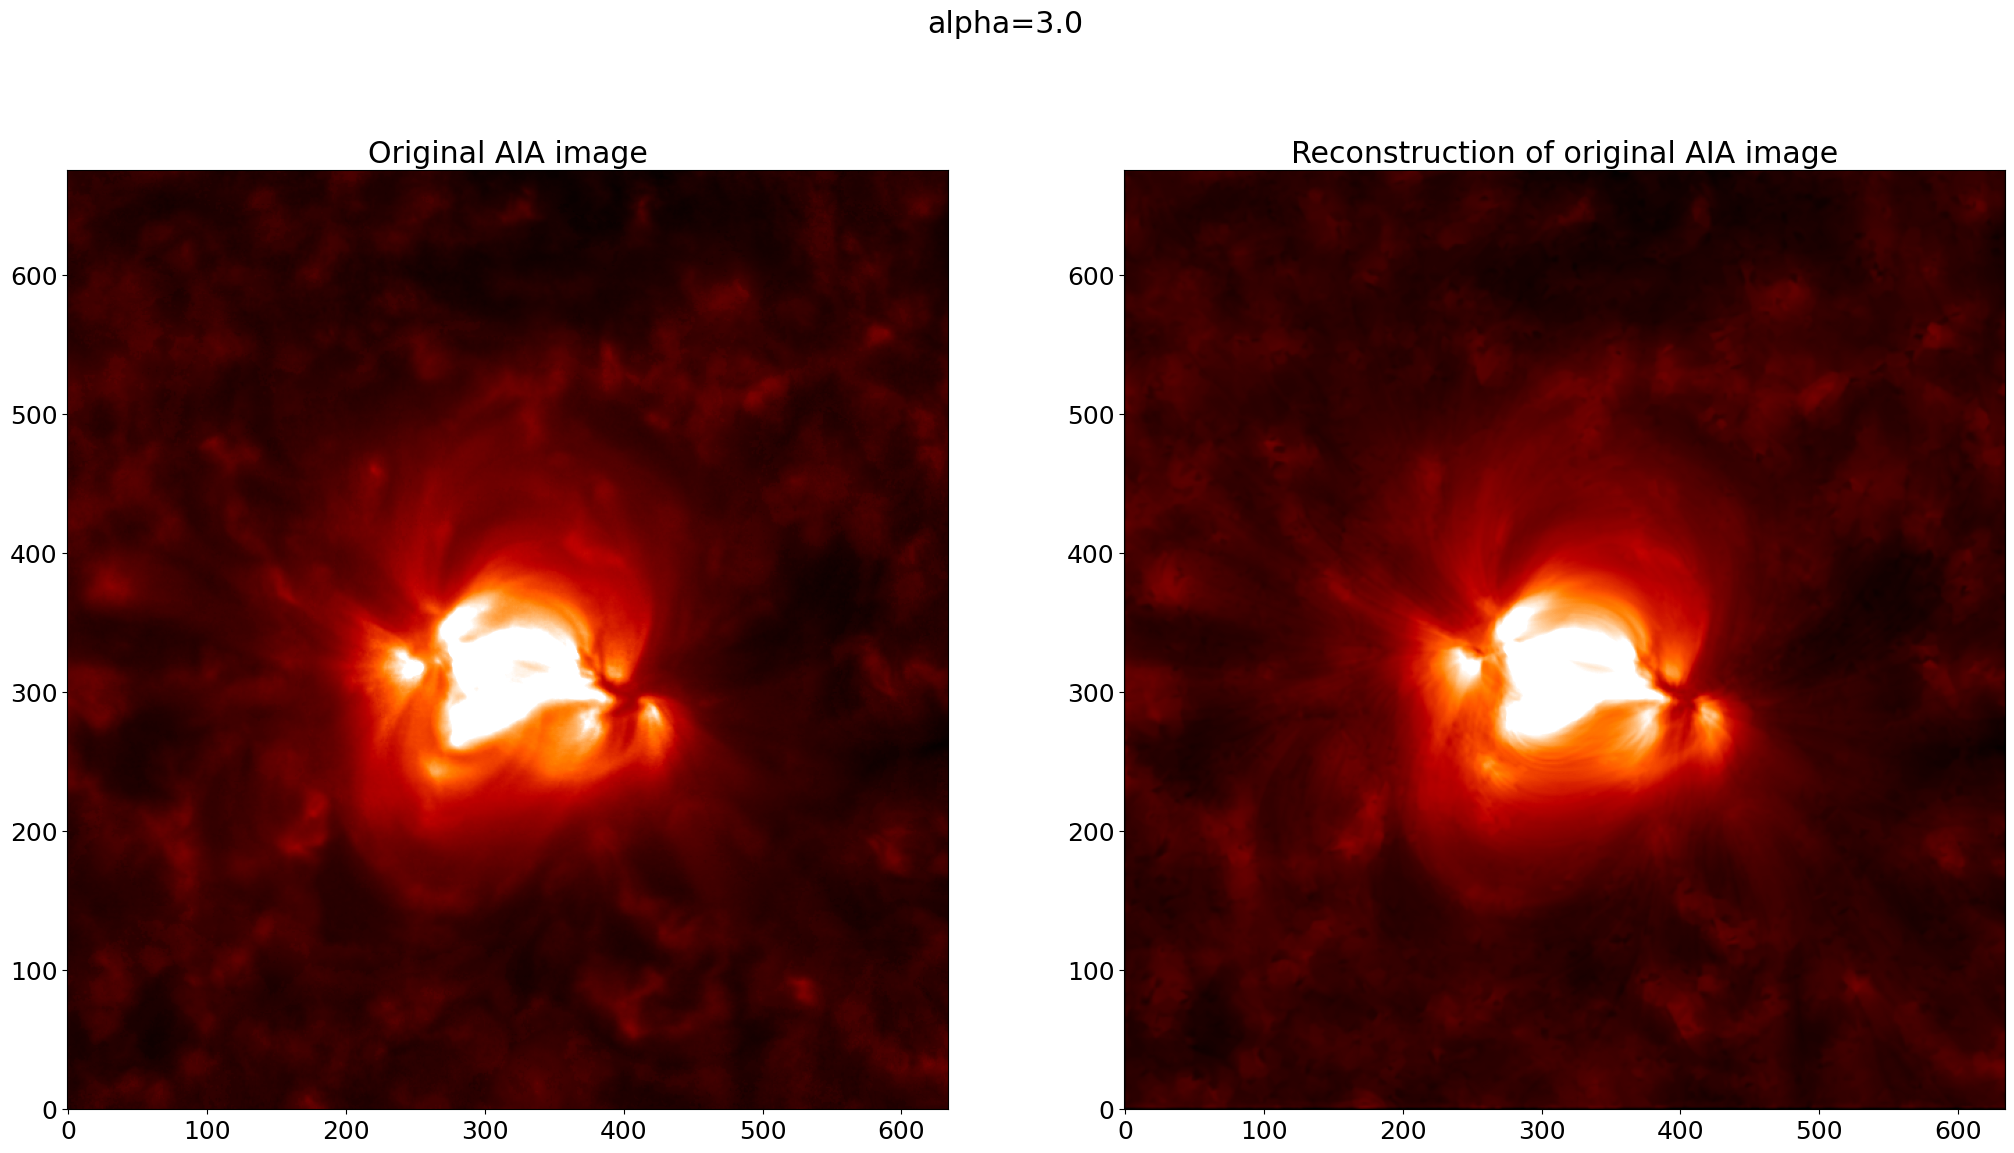

In [30]:
pltmax = 15000

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=[25,13])
plt.suptitle('alpha='+alphastr)
axes[0].imshow(data_corr**gfac,cmap=plt.get_cmap('gist_heat'),vmin=1000**gfac,vmax=pltmax**gfac)
axes[0].set(title='Original AIA image')
axes[1].imshow(aia_only_recon_dat_aia**gfac,cmap=plt.get_cmap('gist_heat'),vmin=1000**gfac,vmax=pltmax**gfac)
axes[1].set(title='Reconstruction of original AIA image')

In [31]:
em3d_output = {'solution':solution[0], 'chi2':solution[1], 'fit_to_data':solution[1], 'emis_configfile':emis_configfile}
np.savez_compressed(emis_savefile,**em3d_output)